In [1]:
from data_imports import *
from data_clean import data
clean_df = data()

In [23]:
class MODEL:
    def __init__(self, input_data, target_var, model):
        """
        Initialize the Model with input data and target variable.

        :param input_data: DataFrame containing the input data.
        :param target_var: Name of the target variable column.
        """
        self.input_data = input_data
        self.target_var = target_var
        self.model = model
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.train_test_metrics = None
        
    def prepare_data(self):
        """
        Prepare data by separating features and target variable,
        and splitting into training and testing sets.
        """
        df_not_missing = self.input_data.dropna(subset=[self.target_var])
        X = df_not_missing.drop(columns=[self.target_var])
        y = df_not_missing[self.target_var]
        
        # Split the data into train and test subsets.
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=1
        )
    
    def train_model(self):
        """
        Train the HistGradientBoostingRegressor model.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Data has not been prepared. Call prepare_data() first.")
        self.model.fit(self.X_train, self.y_train)
    
    def predict(self, new_data):
        """
        Predict target values for new data using the trained model.

        :param new_data: DataFrame containing the new input data.
        :return: Array of predicted values.
        """
        if self.model is None:
            raise ValueError("Model has not been trained. Call train_model() first.")
        return self.model.predict(new_data)
    
    def fill_missing_values(self):
        """
        Predict and fill missing values in the original input data.
        
        :return: DataFrame with missing values filled.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Data has not been prepared. Call prepare_data() first.")
        if self.model is None:
            raise ValueError("Model has not been trained. Call train_model() first.")
        
        df_missing = self.input_data[self.input_data[self.target_var].isnull()]
        if not df_missing.empty:
            X_missing = df_missing.drop(columns=[self.target_var])
            self.input_data.loc[self.input_data[self.target_var].isnull(), self.target_var] = self.model.predict(X_missing)
        
        return self.input_data
    
    def evaluate_model(self):
        """
        Evaluate the model using regression metrics for both training and testing sets.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Data has not been prepared. Call prepare_data() first.")
        if self.model is None:
            raise ValueError("Model has not been trained. Call train_model() first.")
        
        # Predictions on the training and test set.
        y_train_pred = self.model.predict(self.X_train)
        y_test_pred = self.model.predict(self.X_test)

        # Calculating regression metrics for the training set.
        mse_train = mean_squared_error(self.y_train, y_train_pred)
        rmse_train = mse_train ** 0.5
        mae_train = mean_absolute_error(self.y_train, y_train_pred)
        r2_train = r2_score(self.y_train, y_train_pred)

        # Calculating regression metrics for the test set.
        mse_test = mean_squared_error(self.y_test, y_test_pred)
        rmse_test = mse_test ** 0.5
        mae_test = mean_absolute_error(self.y_test, y_test_pred)
        r2_test = r2_score(self.y_test, y_test_pred)
        
        self.train_test_metrics = {
            'train': {'mse': mse_train, 'rmse': rmse_train, 'mae': mae_train, 'r2': r2_train},
            'test': {'mse': mse_test, 'rmse': rmse_test, 'mae': mae_test, 'r2': r2_test}
        }

        # Print training and testing set regression metrics.
        print(f'Training Set - MSE: {mse_train:8.5f}, RMSE: {rmse_train:8.5f}, MAE: {mae_train:8.5f}, R2: {r2_train:8.5f}')
        print(f'Testing Set  - MSE: {mse_test:8.5f}, RMSE: {rmse_test:8.5f}, MAE: {mae_test:8.5f}, R2: {r2_test:8.5f}')
    
    def model_metrics(self):
        """
        Model evaluation metrics, used for plots.
        
        :return: Dictionary of training and testing metrics.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Data has not been prepared. Call prepare_data() first.")
        if self.model is None:
            raise ValueError("Model has not been trained. Call train_model() first.")

        return self.train_test_metrics
    
    def shap_summary(self):
        """
        Summarise the top SHAP features for the model.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Data has not been prepared. Call prepare_data() first.")
        if self.model is None:
            raise ValueError("Model has not been trained. Call train_model() first.")
            
        # SHAP analysis
        explainer = shap.Explainer(self.model)
        self.shap_values = explainer.shap_values(self.X_test)
        shap.summary_plot(self.shap_values, self.X_test)
    
    def shap_top_features(self, top_n):
        """
        Calculate and return the top N features based on SHAP values.

        :param top_n: Number of top features to return.
        :return: DataFrame with the top N features and the target variable.
        """
        if self.X_train is None or self.y_train is None:
            raise ValueError("Data has not been prepared. Call prepare_data() first.")
        if self.model is None:
            raise ValueError("Model has not been trained. Call train_model() first.")

        # Calculate mean absolute SHAP values for each feature
        shap_importance = np.abs(self.shap_values).mean(axis=0)
        top_n_indices = np.argsort(shap_importance)[-top_n:][::-1]  # Indices of the top N features
        top_n_features = self.X_test.columns[top_n_indices]
        
        # Return DataFrame with top N features and target variable
        return self.input_data[top_n_features.to_list() + [self.target_var]]
            

Preparing Model
Training Model
Evaluating Model
Training Set - MSE: 11.54945, RMSE:  3.39845, MAE:  2.59046, R2:  0.78803
Testing Set  - MSE: 12.02467, RMSE:  3.46766, MAE:  2.65498, R2:  0.77958
Model Metrics
Model SHAP Summary


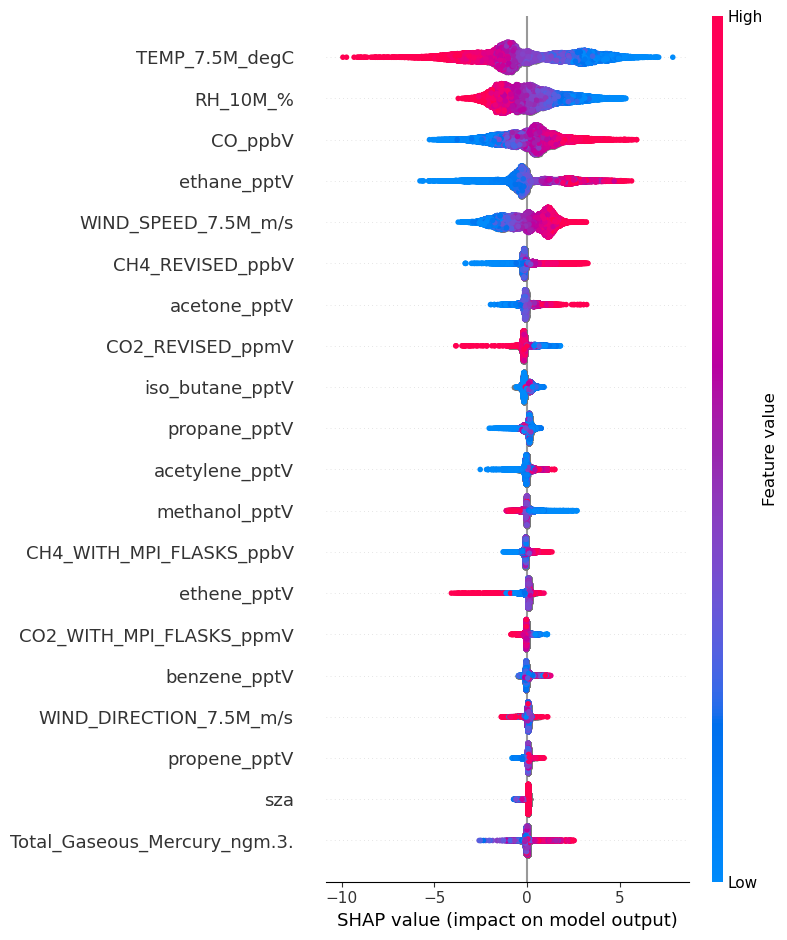

Top SHAP Features


,TEMP_7.5M_degC,RH_10M_%,CO_ppbV,ethane_pptV,WIND_SPEED_7.5M_m/s,O3_ppbV
Date and Time (UTC),,,,,,
2006-10-02 16:00:00,33.8,70.7,NaN,499.48,4.6,17.3
2006-10-02 17:00:00,34.5,70.8,NaN,NaN,4.9,17.9
2006-10-02 18:00:00,36.5,70.4,NaN,499.48,5.1,18.5
2006-10-02 19:00:00,36.8,70.2,NaN,476.07,5.3,19.0
2006-10-02 20:00:00,37.4,70.3,NaN,496.36,5.3,21.2
...,...,...,...,...,...,...
2023-12-31 19:00:00,23.9,83.2,98.518,NaN,4.0,NaN
2023-12-31 20:00:00,24.0,80.0,98.874,NaN,4.3,NaN
2023-12-31 21:00:00,24.0,79.5,99.368,NaN,4.0,NaN


In [24]:
mod = HistGradientBoostingRegressor(random_state=1)
M = MODEL(clean_df, 'O3_ppbV', mod)

print('Preparing Model')
M.prepare_data()

print('Training Model')
M.train_model()

print('Evaluating Model')
M.evaluate_model()

print('Model Metrics')
M.model_metrics()

print('Model SHAP Summary')
M.shap_summary()

print('Top SHAP Features')
M.shap_top_features(top_n=5)



In [26]:
M.evaluate_importance(5)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- ATM_PRESSURE_7.5M_hPa
- CH4_REVISED_ppbV
- CH4_WITH_MPI_FLASKS_ppbV
- CO2_REVISED_ppmV
- CO2_WITH_MPI_FLASKS_ppmV
- ...


In [16]:
L = M.shap_top_features(15)
C = MODEL(L, 'O3_ppbV', mod)
C.prepare_data()
C.train_model()
C.evaluate_model()

Training Set - MSE: 12.64969, RMSE:  3.55664, MAE:  2.70937, R2:  0.76784
Testing Set  - MSE: 13.07726, RMSE:  3.61625, MAE:  2.77551, R2:  0.76028
